<h4>Necessary Modules Import</h4>

In [1]:
pip install faker

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import random
from faker import Faker
from datetime import timedelta
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.decomposition import PCA

<h4>Synthetic Data Generation - Credit Card Company Transactions on April 1st 2025 <br>
(T1078 - Valid Accounts and T1657 - Financial Theft)</h4>

In [3]:
fake = Faker()
def fakeCardNumber():
    return fake.random.randint(1000,9999)
def genuineTransactions(n):
    data = []
    categories = ["Telecom", "Food", "Leisure", "Education","Healthcare", "Municipal Fees", "Clothing", "Electricity Bill", "Water Bill", "Cables Bill","Other"]
    clients = [fake.name() for i in range(n)]
    for i in range(n):
        timestamp = pd.Timestamp("2025-04-01 06:00") + timedelta(seconds=random.randint(0,18*60*60-1))
        data.append({
            "Time" : timestamp,
            "Client" : random.choice(clients),
            "LastDigits" : fakeCardNumber(),
            "Amount" : round(random.uniform(1.0,10000.0),2),
            "Category" : random.choice(categories),
            "CardShown" : random.choice([0,1]),
            "isBusiness" : random.choice([0,1]),
            "CVVdialed" : random.choice([0,1]),
            "Success" : np.random.choice([0,1],p=[0.2,0.8]),
            "genuine" : 1
        })
    return data
def rogueTransactions(n):
    data = []
    categories = ["Food", "Leisure","Other"]
    clients = [fake.name() for i in range(n)]
    for i in range(n):
        timestamp = pd.Timestamp("2025-04-01 00:00") + timedelta(seconds=random.randint(0,24*60*60-1))
        data.append({
            "Time" : timestamp,
            "Client" : random.choice(clients),
            "LastDigits" : fakeCardNumber(),
            "Amount" : round(random.uniform(1.0,20000.0),2),
            "Category" : random.choice(categories),
            "CardShown" : random.choice([0,1]),
            "isBusiness" : random.choice([0,1]),
            "CVVdialed" : random.choice([0,1]),
            "Success" : np.random.choice([0,1],p=[0.8,0.2]),
            "genuine" : 0
        })
    return data


<h4>Dataset Creation</h4>

In [4]:
normal = genuineTransactions(500)
anomalies = rogueTransactions(20)
df = pd.DataFrame(normal + anomalies)
df = df.sample(frac=1).reset_index(drop=True) #shuffle dataframe entries
df

,Time,Client,LastDigits,Amount,Category,CardShown,isBusiness,CVVdialed,Success,genuine
0,2025-04-01 06:55:58,Michael Cook DVM,1893,7540.54,Cables Bill,1,0,1,1,1
1,2025-04-01 07:37:51,Patricia Arnold,8009,2814.98,Municipal Fees,0,0,1,1,1
2,2025-04-01 14:29:24,Patricia Coffey,2230,5930.86,Electricity Bill,1,1,1,1,1
3,2025-04-01 13:53:53,Katie Martinez,2042,432.92,Municipal Fees,0,1,1,1,1
4,2025-04-01 08:48:03,Toni Tucker,4131,3816.38,Education,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...
515,2025-04-01 20:22:53,Michael Leonard,7578,391.08,Clothing,1,0,0,1,1
516,2025-04-01 13:09:41,Anna Young,4443,2282.50,Leisure,0,1,1,1,1
517,2025-04-01 19:56:17,Jo Wagner,9653,5668.08,Education,1,0,1,1,1
518,2025-04-01 23:13:41,Stacy King,1060,4034.45,Education,0,0,0,1,1


<h4>EDA</h4>

<h5>basic dataset statistics</h5>

In [5]:
print("number of rows: ", df.shape[0])
print("number of columns: ", df.shape[1])
print(f"There are {(df["genuine"]==1).sum()} normal values in the dataset and {(df["genuine"]==0).sum()} anomalies")

number of rows:  520
number of columns:  10
There are 500 normal values in the dataset and 20 anomalies


<h5>Visualizations</h5>

Text(0.5, 1.0, 'Distribution of Transactions during 2025-04-01')

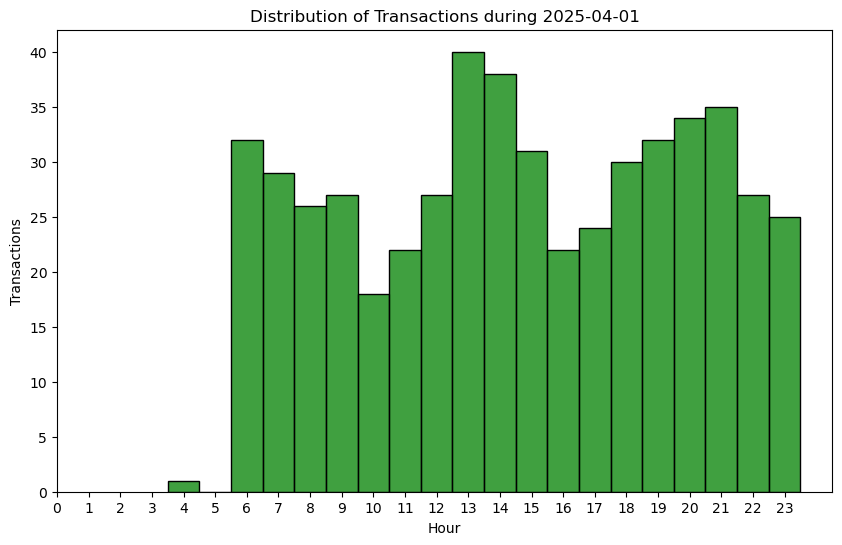

In [6]:
plt.figure(figsize=(10,6))
sns.histplot(df["Time"].dt.hour, bins = 24, discrete=True,color="green")
plt.xticks(range(0,24))
plt.xlabel("Hour")
plt.ylabel("Transactions")
plt.title("Distribution of Transactions during 2025-04-01")

Text(0.5, 1.0, 'scatterplot - different types of credit card usage')

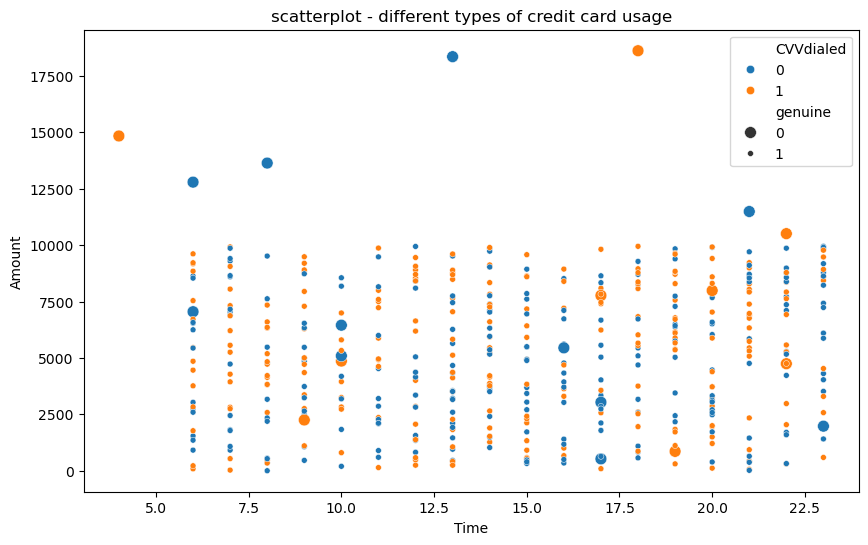

In [7]:
plt.figure(figsize=(10,6))
sns.scatterplot(x= df["Time"].dt.hour, y='Amount', data=df, hue='CVVdialed', size='genuine', palette='tab10')
plt.title("scatterplot - different types of credit card usage")

<h4>Analytical Summary</h4>
<pre>
The normal entries in the synthetically generated dataset resemble normal and reasonable patterns of credit card usage: purchases made in reasonable hours, both physically and online, which are categorized to a wide variety of categories for day-to-day payments.
The anomalies in the dataset represent a typical use of a stolen credit card details/physical card: not limited to reasonable hours, used for much fewer purchase categories, a wider range for the amount spent in each purchase, and much lower chances for the transaction to be completed sucessfully.
The times, the categories, success and amount, are the features that differ normal entries from anomalies, and this difference will assist the models in their classifications.  
</pre>

<h4>Model Application</h4>

In [8]:
X = df.drop(["genuine"],axis=1)
y = df["genuine"]
#scaling the numerical features and encoding categorical features at once with ColumnTransformer
specifications = ColumnTransformer(transformers=[('numeric',StandardScaler(),["Amount"]),('categorical',OneHotEncoder(sparse_output=False, drop="first"),["Category"])])
new_X = specifications.fit_transform(X)
IsoForest = IsolationForest(contamination=0.038,random_state=42) #contamination value just tells the model what precentage of the data is anomolous, it doesn't affect it's scoring
IsoForest.fit(new_X)
y_pred = IsoForest.predict(new_X)
scores = IsoForest.decision_function(new_X)

<h4>Evaluation</h4>

Text(0.5, 1.0, 'Histogram of IsolationForest anomaly scores')

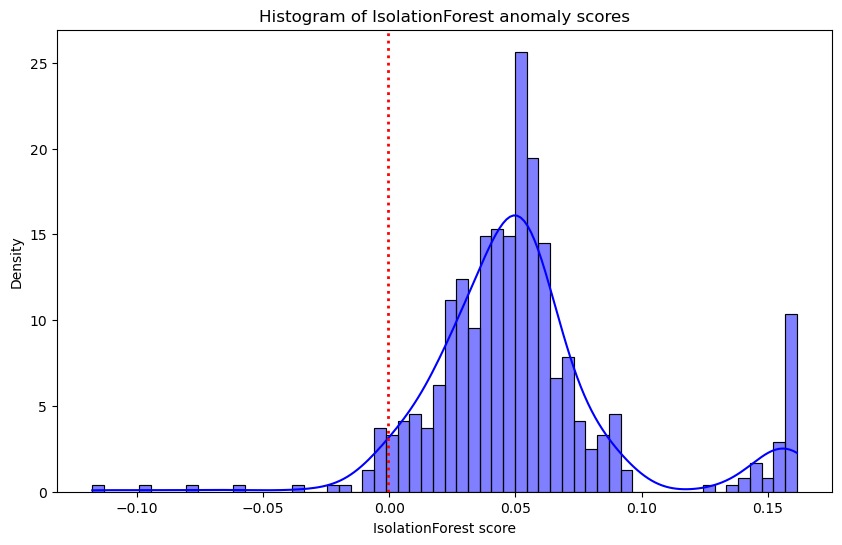

In [9]:
threshold = scores[y_pred == -1].max() #threshold is the maximum score of the entry that was classified as an anomaly
scores_df = pd.DataFrame({"score": scores, "anomalies": (scores<=threshold).astype(int)})
plt.figure(figsize=(10,6))
sns.histplot(scores_df["score"],bins=60, kde=True,color='blue', stat="density")
plt.axvline(threshold, color="red", linestyle=":", linewidth=2)
plt.xlabel("IsolationForest score")
plt.ylabel("Density")
plt.title("Histogram of IsolationForest anomaly scores")

In [10]:
print(f"The model has detected {len([x for x in y_pred if x==-1])} anomalies")

The model has detected 20 anomalies


              precision    recall  f1-score   support

          -1      0.300     0.300     0.300        20
           1      0.972     0.972     0.972       500

    accuracy                          0.946       520
   macro avg      0.636     0.636     0.636       520
weighted avg      0.946     0.946     0.946       520



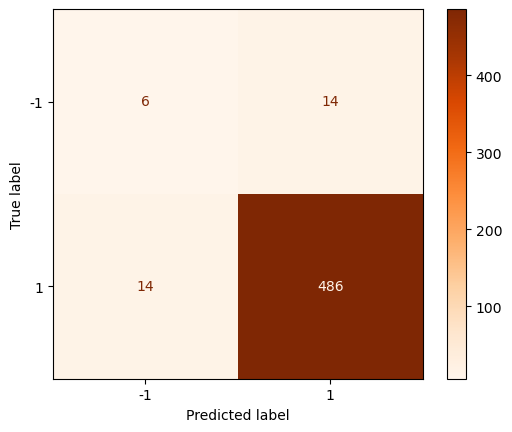

In [11]:
y_rep = [1 if x == 1 else -1 for x in y]
ConfusionMatrixDisplay.from_predictions(y_pred,y_rep,cmap="Oranges")
print(classification_report(y_rep, y_pred, digits=3))

<h4>2D projection of the results - Principal Components in relation to Model Classification</h4>

Text(0.5, 1.0, 'Principal Components in Relation to Model Classification')

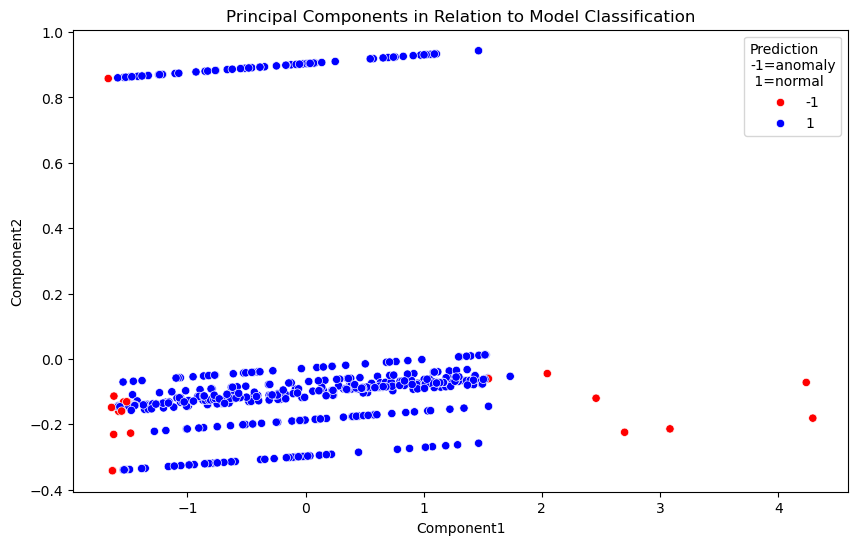

In [12]:
pca = PCA(n_components=2)
X_PCA = pca.fit_transform(new_X)
df_PCA = pd.DataFrame(data=X_PCA, columns=["Component1", "Component2"])
df_PCA["Prediction"] = y_pred
plt.figure(figsize=(10,6))
sns.scatterplot(data=df_PCA, x= "Component1", y="Component2", hue="Prediction",palette={-1:'red', 1:'blue'})
plt.legend(title="Prediction\n-1=anomaly\n 1=normal")
plt.title("Principal Components in Relation to Model Classification")

<h4>Summary:</h4>

<pre>
By looking at the 2D projection of the models classification in relation to the two principale components chosen by PCA, we can see that the normal transactions are stacked together, and the anomalous transactions appear at their edges or appear apart from them.
This generally matches what can be seen in the scatterplot created in the EDA section: few anomalies are distinctly far from the rest of the data, and some are intertwined with it. This observation may indicate that one of the most influencial feature on the principal components chosen by PCA was the time feature, as it implies a similar distribution of the data as a whole, and the anomalies in it in particular.
</pre>